In [5]:
# ------------------------
# Date format YYYY-MM-DD
# ------------------------

subreddit = "croatiaalt"
after_date = "2023-01-01"
before_date = "2024-01-01"
outdir = "./data/"
plotsdir = "./plots/"

In [6]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import urllib.request

In [7]:
fetch_py_url = "https://gist.githubusercontent.com/fr02t1/3110c3a7012f13f10ceacbbb726d997c/raw/1782d000facd582c3b4b143e071dbb2d65a20ff2/fetch.py"
urllib.request.urlretrieve(fetch_py_url, "fetch.py")
os.makedirs(outdir, exist_ok=True)
os.makedirs(plotsdir, exist_ok=True)

Koristi se za download podataka u jsonl formatu


In [8]:
!python ./fetch.py --comments --sub $subreddit --dir $outdir --after $after_date --before $before_date

In [9]:
def getAurhor(filename: str) -> dict:
    authors = {}
    count = 0
    start = time.time()
    with open(filename, 'r') as f:
        for line in f:
            count += 1
            print("Line {}: | Time Elapsed: {} ".format(count, time.time() - start), end='\r')
            comment = json.loads(line)
            author = comment.get('author')
            if author in authors:
                authors[author] += 1
            else:
                authors[author] = 1
    return authors, count # return dictionary of authors and their comments count

def plot_comment_counts(comment_dict: dict):
    # Convert the dictionary to a Pandas Series and sort by values
    comment_counts = pd.Series(comment_dict).sort_values(ascending=False)

    # add the author column to the y axis
    comment_counts.index.name = 'author'
    comment_counts = comment_counts.reset_index()

    # Plot the number of comments for the top 10 authors
    sns.barplot(x='author', y='comment', data=comment_counts.head(10))

    # Display the graph
    plt.show()

In [10]:
def getStartEndDate(filename: str) -> tuple:
    with open(filename, 'r') as f:
        first_line = f.readline()
        first_comment = json.loads(first_line)
        start_date = first_comment['created_utc']

        last_line = None
        for last_line in f:
            pass
        last_comment = json.loads(last_line)
        end_date = last_comment['created_utc']

    return start_date, end_date

In [11]:
filename = outdir + 'comments_' + subreddit + '_' + ('before_' + before_date + '_' if before_date else '') + (
                                                     'after_' + after_date if after_date else '') + '.json'
authors, total_count = getAurhor(filename)
start_date, end_date = getStartEndDate(filename)

In [15]:
# print the top 10 authors
def plotTopAuthor(authors, total_count):
  top_total = 20
  print('Top 10 authors:')
  for author, comment_count in sorted(authors.items(), key=lambda x: x[1], reverse=True)[:30]:
      # remove from the dict if the author is [deleted]
      if author == '[deleted]':
          del authors[author]
          continue
      if author == 'AutoModerator':
        del authors[author]
        continue
      if author == 'flairassistant':
        del authors[author]
        continue

      #print(f'{author}: {comment_count}')

  df = pd.DataFrame.from_dict(authors, orient='index', columns=['comment'])
  # sort by comment count
  df = df.sort_values(by=['comment'], ascending=False)
  ax = df.head(top_total).plot(kind='barh', figsize=(10, 6), color='#86bf91', zorder=2, width=0.85)
  # add the author number to the bar
  for i, v in enumerate(df.head(top_total)['comment']):
      ax.text(v + 3, i + .25, str(v), color='black', fontweight='bold')

  # invert the graph so the largest bar is at the top
  ax.invert_yaxis()

  # add labels and title
  ax.set_xlabel('Broj komentara')
  ax.set_ylabel('Author')
  ax.set_title('Broj komentara po autoru na subredditu /r/' + subreddit + '\n' +
              'od '  + time.strftime('%Y-%m-%d', time.localtime(start_date)) +
              ' do ' + time.strftime('%Y-%m-%d', time.localtime(end_date)), fontsize=10)
          

  plt.figtext(0.95, 0.95, 'Ukupan broj komentara: ' + str(total_count), ha="right", va="bottom", fontsize=8)

  now = datetime.datetime.now()
  date = now.strftime("%Y-%m-%d")

  # put it in the top right corner of the canvas
  plt.figtext(0.95, 0.05, date, ha="right", va="bottom", fontsize=8)
  plt.figtext(0.95, 0.02, 'Izvor: arctic-shift.photon-reddit.com', ha="right", va="bottom", fontsize=8)

  # add the created by Fluid-Pirate646
  plt.figtext(-0.08, 0.01, 'Created by /u/Fluid-Pirate646', ha="left", va="bottom", fontsize=8)

  # display the graph
  plt.show()
  plt.savefig(plotsdir + 'comment_count_' + subreddit + '.png', dpi=300, bbox_inches='tight')


Top 10 authors:


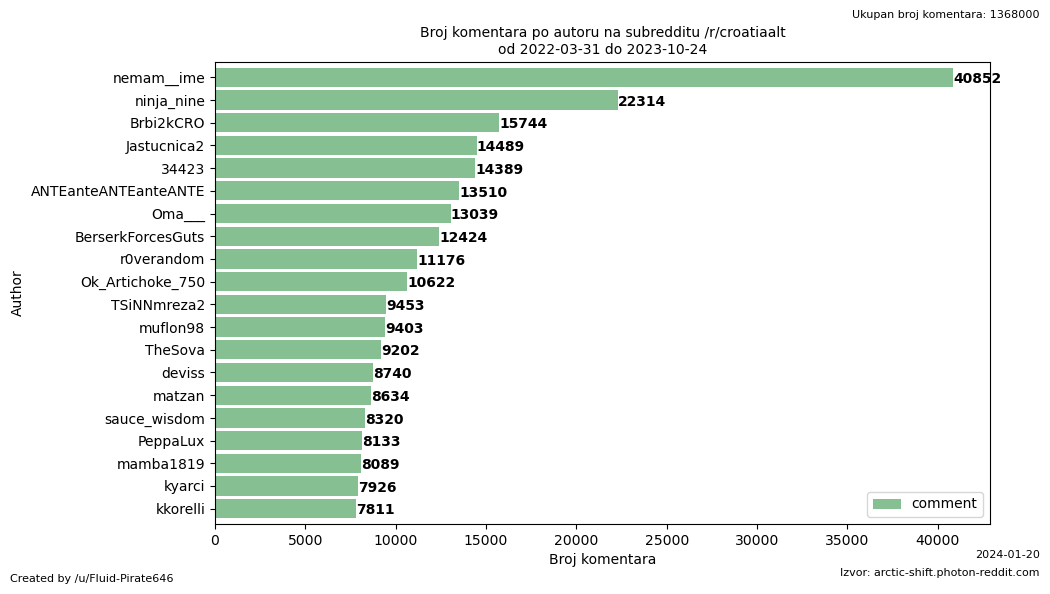

<Figure size 640x480 with 0 Axes>

In [16]:
plotTopAuthor(authors, total_count)